<a href="https://colab.research.google.com/github/up1512001/Machine-Learning/blob/up1512001-patch-26/CIFAR10_ResNets_and_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url

In [2]:
# downloading dataset
dataset_url = 'https://files.fast.ai/data/examples/cifar10.tgz'
download_url(dataset_url,'.')

# extracting from archive
with tarfile.open('./cifar10.tgz','r:gz') as tar:
    tar.extractall(path='./data')


data_dir = './data/cifar10'
# Look inside dataset directory
print(os.listdir(data_dir))
classes = os.listdir(data_dir+'/train')
print(classes)


['test', 'labels.txt', 'train']
['frog', 'ship', 'airplane', 'horse', 'bird', 'deer', 'automobile', 'cat', 'dog', 'truck']


In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

In [4]:
# data transforms (normalization & Data augmentation)
stats = ((0.4914,0.4822,0.4465),(0.2023,0.1994,0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32,padding=4,padding_mode='reflect'),
                        tt.RandomHorizontalFlip(),
                        tt.ToTensor(),
                        tt.Normalize(*stats)])
valid_tfms = tt.Compose([tt.ToTensor(),tt.Normalize(*stats)])

In [5]:
# PyTorch Datasets
train_ds = ImageFolder(data_dir+'/train',train_tfms)
valid_ds = ImageFolder(data_dir+'/test',valid_tfms)

In [6]:
# creating data loaders to retrive images in batch

from torch.utils.data import DataLoader

In [7]:
batch_size = 256

In [8]:
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=8,pin_memory=True)
valid_dl = DataLoader(valid_ds,batch_size,shuffle=False,num_workers=8,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
# num_workers=8 tells pytorch that it can use 8 CPU cores to load batch of image and 
# pin_memory=True tells that same memory will be allocated for each batch so I/O can become easy

In [10]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [11]:
def show_batch(dl):
    for images,labels in dl:
        fig,ax = plt.subplots(figsize=(16,16))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(images[:100],10).permute(1,2,0))
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


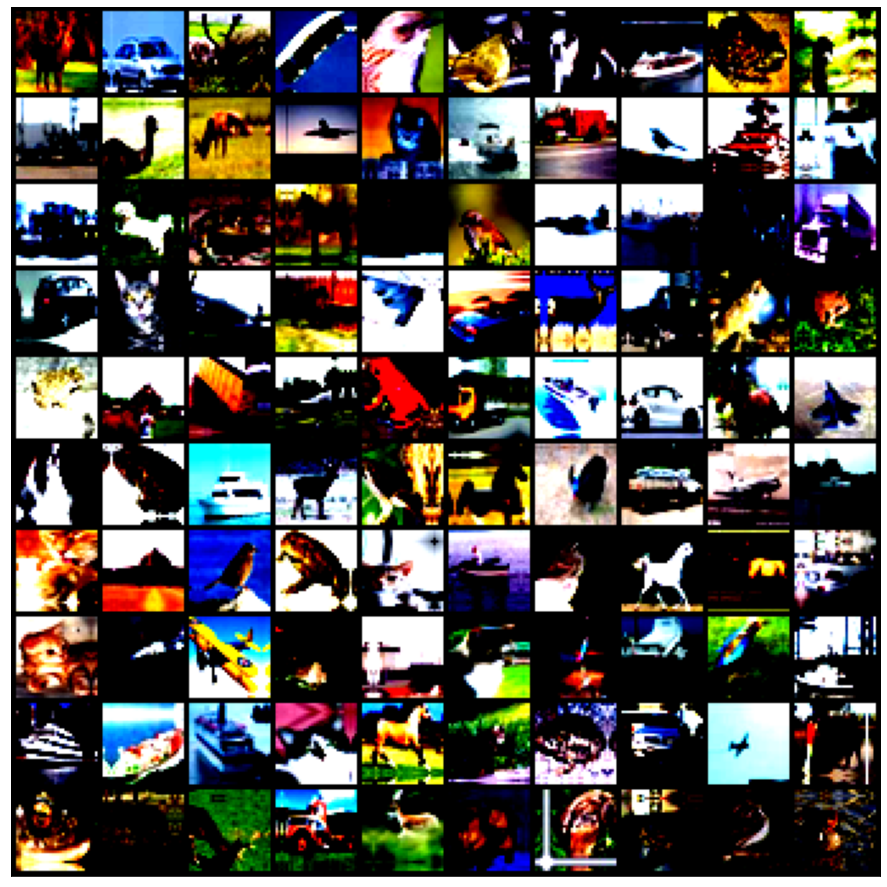

In [12]:
show_batch(train_dl)

In [13]:
# we will use WideResNet22 which has 22 convolutional layers

In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3,out_channels=3,kernel_size=3,stride=1,padding=1)
        self.relu2 = nn.ReLU()
        
    def forward(self,x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out+x)

In [16]:
simple_resnet = SimpleResidualBlock()

for images,labels in train_dl:
    out = simple_resnet(images)
    print(out.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([256, 3, 32, 32])


In [17]:
def conv_2d(ni,nf,stride=1,ks=3):
    return nn.Conv2d(in_channels=ni,out_channels=nf,
                    kernel_size=ks,stride=stride,
                    padding=ks//2,bias=False)

def bn_relu_conv(ni,nf):
    return nn.Sequential(nn.BatchNorm2d(ni),
                        nn.ReLU(inplace=True),
                        conv_2d(ni,nf))

class ResidualBlock(nn.Module):
    def __init__(self,ni,nf,stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni,nf,stride)
        self.conv2 = bn_relu_conv(nf,nf)
        self.shortcut = lambda x: x
        if ni !=nf:
            self.shortcut = conv_2d(ni,nf,stride,1)
            
    def forward(self,x):
        x = F.relu(self.bn(x),inplace=True)
        r = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

In [18]:
def make_group(N,ni,nf,stride):
    start = ResidualBlock(ni,nf,stride)
    rest = [ResidualBlock(nf,nf) for j in range(1,N)]
    return [start]+rest

class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self,x):
        return x.view(x.size(0),-1)
    

class WideResNet(nn.Module):
    def __init__(self,n_groups,N,n_classes,k=1,n_start=16):
        super().__init__()
        # increase channels to n start using conv layer
        layers = [conv_2d(3,n_start)]
        n_channels = [n_start]
        
        # add group of Basic Block (increase channels & downsample)
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N,n_channels[i],n_channels[i+1],stride)
            
        # pooling , flatten & add layer for classification
        layers += [nn.BatchNorm2d(n_channels[3]),
                  nn.ReLU(inplace=True),
                  nn.AdaptiveAvgPool2d(1),
                  Flatten(),
                  nn.Linear(n_channels[3],n_classes)]
        
        self.features = nn.Sequential(*layers)
        
    def forward(self,x):
        return self.features(x)
    
def wrn_22():
    return WideResNet(n_groups=3,N=3,n_classes=10,k=6)
    

In [19]:
model = wrn_22()

In [20]:
model

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [21]:
for images,labels in train_dl:
    print('images.shape :',images.shape)
    out = model(images)
    print('out.shape :',out.shape)
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape : torch.Size([256, 3, 32, 32])
out.shape : torch.Size([256, 10])


In [22]:
# !pip install fastai

In [23]:
from fastai.basic_data import DataBunch
from fastai.train import Learner
from fastai.metrics import accuracy

In [24]:
data = DataBunch.create(train_ds,valid_ds,bs=batch_size,path='./data/cifar10')
learner = Learner(data,model,loss_func=F.cross_entropy,metrics=[accuracy])
learner.clip = 0.1

In [25]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


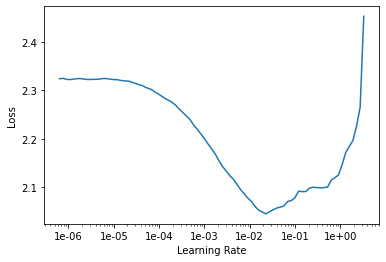

In [26]:
learner.recorder.plot()

In [27]:
# from above plot we can clearly see that at 1e-3 (0.001) learning rate is stepest so we will pick this as model learning rate

In [28]:
learner.fit_one_cycle(10,1e-3,wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.490239,1.324660,0.521900,01:01
1,1.056981,1.092914,0.616300,01:01
2,0.808445,1.087049,0.654100,01:01
3,0.625588,0.700385,0.770700,01:01
4,0.508147,0.533624,0.822100,01:01
5,0.420188,0.544813,0.809000,01:01
6,0.329829,0.401171,0.866300,01:01
7,0.272407,0.323549,0.890200,01:01
8,0.220811,0.296513,0.897800,01:01
9,0.197088,0.293233,0.901500,01:01


In [29]:
# wd = 1e-4 weight decay to penalize larger values

In [30]:
# data augmenting and batch normalization helps to increase model accuracy

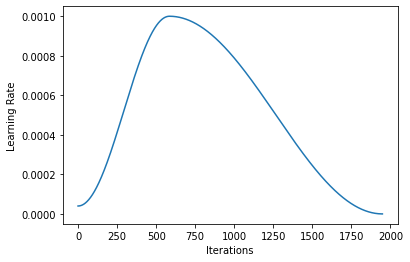

In [31]:
learner.recorder.plot_lr()

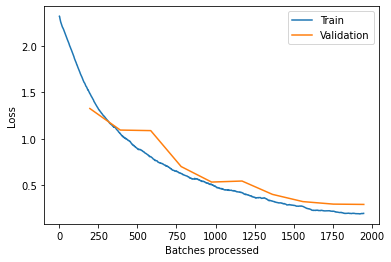

In [32]:
learner.recorder.plot_losses()

In [33]:
# This model max goes upto 96 to 97 percent 

In [35]:
torch.save(model.state_dict(),'cifar10-wrn22.pth')

In [ ]:
learner.fit_one_cycle(30,2e-2,wd=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.379756,0.663954,0.801300,01:01
1,0.481241,1.079879,0.698100,01:01
2,0.535491,1.082949,0.679600,01:01
3,0.521096,0.660493,0.794600,01:01
4,0.515022,0.626343,0.796200,01:01
5,0.465908,0.589254,0.802100,01:01
6,0.433447,0.508120,0.834100,01:01
